In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import pandas as pd
import geobr
import xarray as xr

pd.set_option('future.no_silent_downcasting', True)

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
from shapely.geometry import mapping

def plot_spatial_field(
    da, region_gdf, stations_df=None,
    title="", cmap="YlOrRd", vmin=None, vmax=None, levels=None):

    da = da.rio.write_crs("EPSG:4326", inplace=True)
    da_crop = da.rio.clip([mapping(region_gdf.unary_union)], region_gdf.crs, drop=True)

    xmin, ymin, xmax, ymax = region_gdf.total_bounds
    xmin = math.floor(xmin * 2) / 2
    xmax = math.ceil(xmax * 2) / 2
    ymin = math.floor(ymin * 2) / 2
    ymax = math.ceil(ymax * 2) / 2

    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})

    im = da_crop.plot(
        ax=ax,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        levels=levels,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

    region_gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([xmin, xmax, ymin, ymax])

    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color="gray", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    ax.tick_params(labelsize=7)

    if stations_df is not None and not stations_df.empty:
        ax.scatter(
            stations_df["longitude"],
            stations_df["latitude"],
            color="black",
            s=15,
            marker="o",
            transform=ccrs.PlateCarree(),
            label="Estaciones INMET"
        )        for _, row in stations_df.iterrows():
            ax.text(
                float(row["longitude"]) + 0.05,
                float(row["latitude"]) + 0.05,
                row["station_id"],
                fontsize=6,
                transform=ccrs.PlateCarree()
            )

    if title:
        ax.set_title(title, fontsize=10, loc="left")        

    cbar = plt.colorbar(im, orientation="vertical", pad=0.05, aspect=50, shrink=0.7)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label("Temperatura (°C)", fontsize=9)

    plt.show()


def load_municipality():
    muni = geobr.read_municipality(code_muni="SP")
    muni = muni.to_crs("EPSG:4326")
    return muni, muni.unary_union

def load_state():
    state = geobr.read_state(code_state="SP")
    state = state.to_crs("EPSG:4326")
    return state, state.unary_union

In [3]:

weather_dict = {
    'DATA (YYYY-MM-DD)': 'date',
    'HORA (UTC)': 'hour',
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precipitation',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'atmospheric_pressure',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'max_atmospheric_pressure',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'min_atmospheric_pressure',
    'RADIACAO GLOBAL (KJ/m²)': 'global_radiation',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'air_temperature',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'dew_point_temperature',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'max_air_temperature',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'min_air_temperature',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'max_dew_point_temperature',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'min_dew_point_temperature',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'max_relative_humidity',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'min_relative_humidity',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'relative_humidity',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'wind_direction',
    'VENTO, RAJADA MAXIMA (m/s)': 'max_wind_gust',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'wind_speed'
}


path = '/Users/daniela/Documents/suyana/heat_waves/heatwave_project/data/raw/INMET'

prefix_of_interest = 'INMET_SE_SP_'
list_of_years = [i for i in range(2000, 2026)]


In [4]:

df_list = []
meta_list = []

for year in list_of_years:
    print(year)
    year_path = os.path.join(path, str(year))
    if not os.path.exists(year_path):
        print(f"No folder for {year}")
        continue

    files = [
        f for f in os.listdir(year_path)
        if f.startswith(prefix_of_interest) and f.endswith(".CSV")
    ]
    if not files:
        print(f"No files for {year}")
        continue

    for file_name in files:
        file_path = os.path.join(year_path, file_name)
        try:
            with open(file_path, 'r', encoding='latin-1') as f:
                meta_lines = [next(f) for _ in range(8)]

            meta_dict = {}
            for line in meta_lines:
                parts = line.strip().split(':', 1)
                if len(parts) >= 2:
                    key = parts[0].strip()
                    value = parts[1].strip().replace(',', '.').strip('; ').strip()
                    meta_dict[key] = value

            data = pd.read_csv(
                file_path,
                skiprows=8,
                encoding='latin-1',
                sep=';',
                on_bad_lines='warn',
                dtype='object'
            )

            data = data.replace('-9999', np.nan).replace(',', '.', regex=True)
            if 'Unnamed: 19' in data.columns:
                data = data.drop(columns=['Unnamed: 19'])

            date_col = [c for c in data.columns if 'DATA' in c.upper() or 'Data' in c]
            hour_col = [c for c in data.columns if 'HORA' in c.upper() or 'Hora' in c]
            if not date_col or not hour_col:
                print(f"Missing date/hour in {file_name}")
                continue

            data = data.rename(columns={date_col[0]: 'date', hour_col[0]: 'hour'}, errors='ignore')
            data = data.rename(columns=weather_dict, errors='ignore')

            data['date'] = pd.to_datetime(data['date'], errors='coerce')
            data['hour'] = data['hour'].astype(str).str.replace('UTC', '', regex=False)
            data['hour'] = data['hour'].str.replace(r'(\d{2})(\d{2})', r'\1:\2', regex=True)
            data['datetime'] = pd.to_datetime(
                data['date'].dt.strftime('%Y-%m-%d') + ' ' + data['hour'],
                errors='coerce'
            )

            data = data.drop(columns=['date', 'hour'])
            data = data.set_index('datetime')

            m = re.search(r'_([A-Z]\d{3})_(.*?)_', file_name)
            if m:
                station_code, station_name = m.groups()
            else:
                station_code, station_name = np.nan, np.nan

            data['station_id'] = station_code
            data['station_name'] = station_name.strip() if isinstance(station_name, str) else np.nan
            data['year'] = year

            for k, v in [('LATITUDE', 'latitude'), ('LONGITUDE', 'longitude'), ('ALTITUDE', 'altitude')]:
                if k in meta_dict:
                    try:
                        data[v] = float(meta_dict[k])
                    except ValueError:
                        data[v] = np.nan

            df_list.append(data)

            meta_entry = {
                'station_id': station_code,
                'station_name': station_name,
                'region': meta_dict.get('REGIÃO', None),
                'uf': meta_dict.get('UF', None),
                'latitude': meta_dict.get('LATITUDE', None),
                'longitude': meta_dict.get('LONGITUDE', None),
                'altitude': meta_dict.get('ALTITUDE', None),
                'foundation_date': meta_dict.get('DATA DE FUNDAÇÃO (YYYY-MM-DD)', None)
            }
            meta_list.append(meta_entry)

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

df = pd.concat(df_list, ignore_index=False) if df_list else pd.DataFrame()
meta_df = pd.DataFrame(meta_list).drop_duplicates(subset=['station_id'])

for col in ['latitude', 'longitude', 'altitude']:
    meta_df[col] = meta_df[col].astype(str).str.replace(';', '').str.strip()
    meta_df[col] = pd.to_numeric(meta_df[col], errors='coerce')

meta_df['region'] = meta_df['region'].astype(str).str.replace(';', '').str.strip()
meta_df['uf'] = meta_df['uf'].astype(str).str.replace(';', '').str.strip()
meta_df['foundation_date'] = meta_df['foundation_date'].astype(str).str.replace(';', '').str.strip()

2000
No files for 2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025


In [19]:
df = df[df['station_id']!='C891'].copy()

meta_df = meta_df[meta_df['station_id']!='C891'].copy()

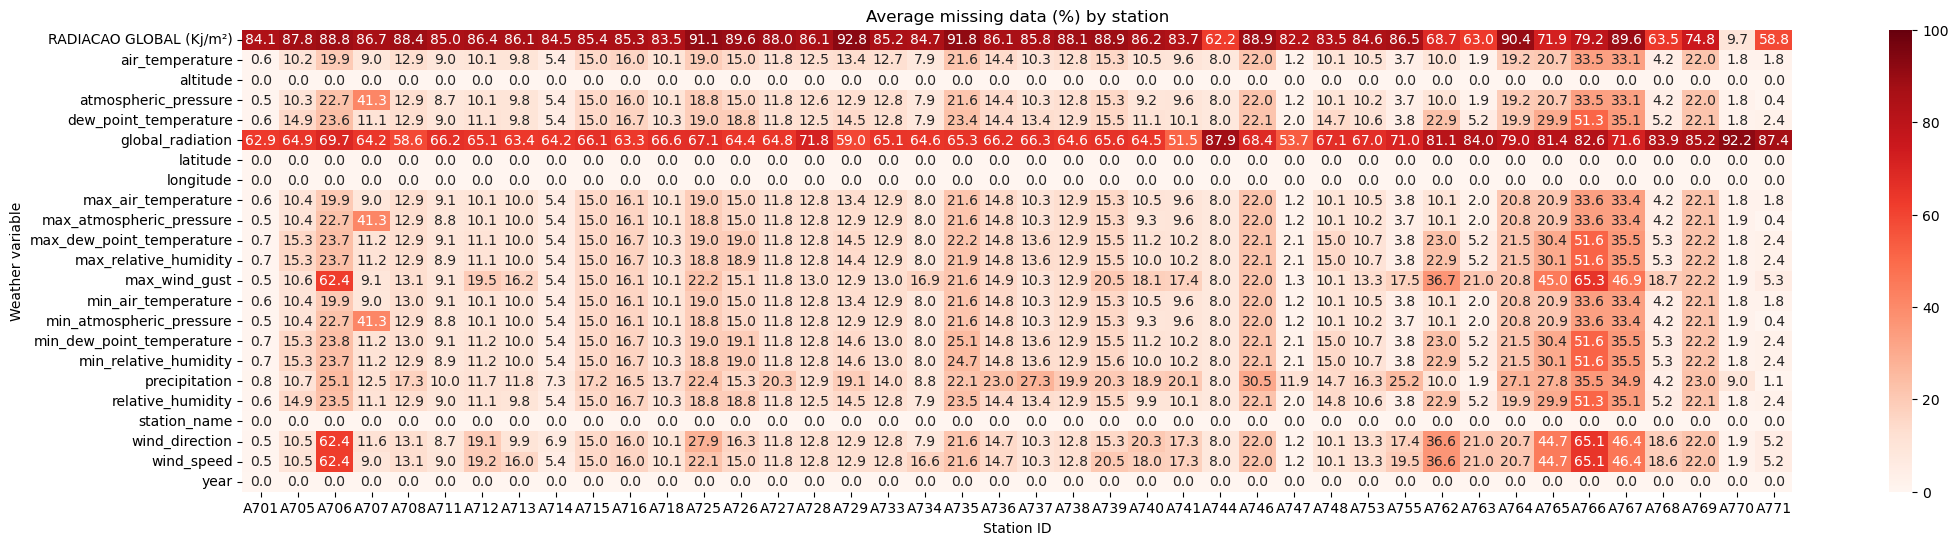

In [20]:

data = (
    df.groupby('station_id')
        .apply(lambda x: x.isna().sum() / x.shape[0], include_groups=False)
        .reset_index()
        .melt(id_vars='station_id', var_name='weather_variable', value_name='missing')
)

data = data.groupby(['station_id', 'weather_variable']).mean().reset_index()
data = data.pivot(index='weather_variable', columns='station_id', values='missing') * 100

plt.figure(figsize=(25, 6))
plt.title('Average missing data (%) by station')
sns.heatmap(data, vmin=0, vmax=100, cmap='Reds', annot=True, fmt=".1f")
plt.ylabel('Weather variable')
plt.xlabel('Station ID')
plt.show()

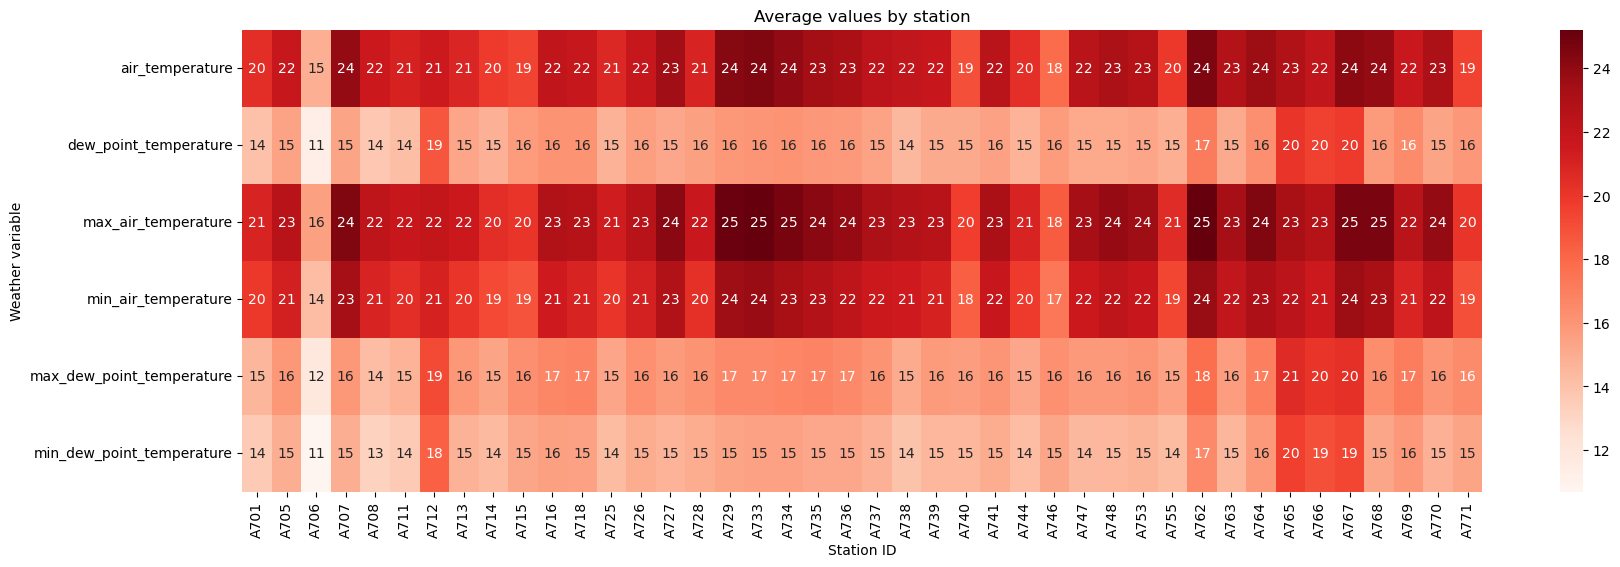

In [21]:
numeric_cols = [
    v for v in weather_dict.values()
    if "temperature" in v and v in df.columns
]

for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

data = (
    df.groupby('station_id')[numeric_cols]
      .mean(numeric_only=True)
      .T
)

plt.figure(figsize=(20,6))
plt.title('Average values by station')
sns.heatmap(data, cmap='Reds', annot=True)
plt.ylabel('Weather variable')
plt.xlabel('Station ID')
plt.show()

/var/folders/8j/y_l8frxs2n19mq92k5pv4y100000gn/T/ipykernel_56170/219901851.py:75: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return muni, muni.unary_union
/var/folders/8j/y_l8frxs2n19mq92k5pv4y100000gn/T/ipykernel_56170/219901851.py:79: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return state, state.unary_union
/var/folders/8j/y_l8frxs2n19mq92k5pv4y100000gn/T/ipykernel_56170/219901851.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  da_crop = da.rio.clip([mapping(region_gdf.unary_union)], region_gdf.crs, drop=True)


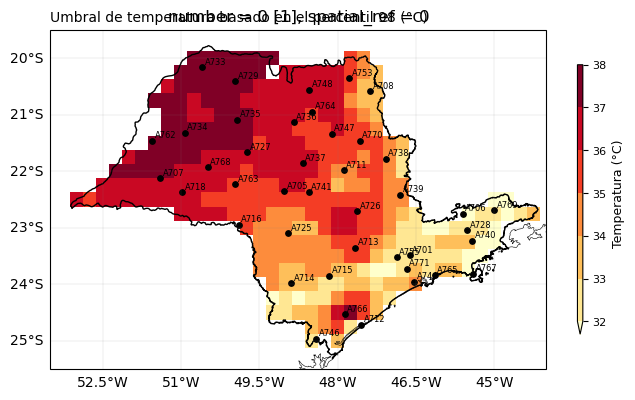

In [22]:
muni, _ = load_municipality()
muni = muni.to_crs("EPSG:4326")
muni_sp = muni[muni["name_muni"] == "São Paulo"]

state, _ = load_state()
state = state.to_crs("EPSG:4326")

data_processed_dir = "../data/processed/"
data_raw_dir = "../data/raw/"

region = [6, -74, -34, -33]

climatology_years = [1995, 2024]
file_percentiles = f'tmax2m_mean_and_percentiles_{climatology_years[0]}_{climatology_years[1]}_area_{region[0]}N_{region[1]}W_{region[2]}S_{region[3]}E.nc'
files_raw = sorted([file for file in os.listdir(data_raw_dir) if file.endswith(".nc")])

ds_percentiles = xr.open_dataset(data_processed_dir + file_percentiles)

percentile = 98 
p_percentile = ds_percentiles[f't2m_p{percentile}']
p_percentile_mean = p_percentile.round(0)

plot_spatial_field(
    p_percentile_mean,
    region_gdf=state,
    stations_df=meta_df,
    title="Umbral de temperatura basado en el percentil 98 (°C)",
    cmap="YlOrRd",
    levels=np.arange(32, 39, 1)
)


In [ ]:
df.to_csv('../data/processed/inmet_hourly_data_se_sp_2000_2025.csv', index=True)


In [24]:
meta_df.to_csv('../data/processed/inmet_stations_metadata_se_sp_2000_2025.csv', index=False)